# CLIP Interrogator 2 by [@pharmapsychotic](https://twitter.com/pharmapsychotic) 

<br>

Want to figure out what a good prompt might be to create new images like an existing one? The CLIP Interrogator is here to get you answers!

<br>

This version is specialized for producing nice prompts for use with Stable Diffusion and achieves higher alignment between generated text prompt and source image. You can try out the old [version 1](https://colab.research.google.com/github/pharmapsychotic/clip-interrogator/blob/v1/clip_interrogator.ipynb) to see how different CLIP models ranks terms. 

<br>

If this notebook is helpful to you please consider buying me a coffee via [ko-fi](https://ko-fi.com/pharmapsychotic) or following me on [twitter](https://twitter.com/pharmapsychotic) for more cool Ai stuff. 🙂

And if you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


In [ ]:
#@title Check GPU
!nvidia-smi -L

In [ ]:
#@title Setup
import argparse, subprocess, sys, time

def setup():
    install_cmds = [
        ['pip', 'install', 'ftfy', 'regex', 'tqdm', 'transformers==4.21.2', 'timm', 'fairscale', 'requests'],
        ['pip', 'install', '-e', 'git+https://github.com/openai/CLIP.git@main#egg=clip'],
        ['pip', 'install', '-e', 'git+https://github.com/pharmapsychotic/BLIP.git@lib#egg=blip'],
        ['git', 'clone', '-b', 'lib', 'https://github.com/pharmapsychotic/clip-interrogator.git']
    ]
    for cmd in install_cmds:
        print(subprocess.run(cmd, stdout=subprocess.PIPE).stdout.decode('utf-8'))

setup()

import sys
sys.path.append('src/blip')
sys.path.append('src/clip')
sys.path.append('clip-interrogator')

import clip
import io
import IPython
import ipywidgets as widgets
import requests
import torch

from PIL import Image

from clip_interrogator import Interrogator, Config


In [ ]:
#@title Load CLIP Interrogator
clip_model_name = 'ViT-L/14' #@param ['ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px', 'RN101', 'RN50', 'RN50x4', 'RN50x16', 'RN50x64'] {type:'string'}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = Config(device=device, clip_model_name=clip_model_name)
interrogator = Interrogator(config)


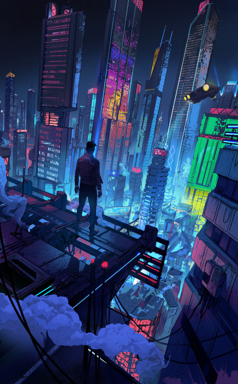

In [7]:
#@title Interrogate

#@markdown Run this cell and then paste a link to an image or upload an image in the UI. Then click the Interrogate button to get a prompt suggestion.

image_url = 'https://cdnb.artstation.com/p/assets/images/images/032/142/769/large/ignacio-bazan-lazcano-book-4-final.jpg'

def show_ui():
    go_button = widgets.Button(
        description='Interrogate!',
        disabled=False,
        button_style='',
        tooltip='Click me'
    )
    image_txt = widgets.Text(
        value=image_url, 
        description='', 
        layout=widgets.Layout(width='50%')
    )
    uploader = widgets.FileUpload(accept='image/*', multiple=False)

    ui = widgets.VBox([
        widgets.HBox([widgets.Label('image url:'), image_txt]),
        widgets.HBox([widgets.Label('or upload:'), uploader]),
        widgets.Label(''),
        go_button
    ])

    def go(btn):
        image_url = image_txt.value
        if len(uploader.value):
            print(uploader.value)
            print(uploader.value.items())
            for name, file_info in uploader.value.items():
                image = Image.open(io.BytesIO(file_info['content'])).convert('RGB')
                break
        else:
            if str(image_url).startswith('http://') or str(image_url).startswith('https://'):
                image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
            else:
                image = Image.open(image_url).convert('RGB')

        IPython.display.clear_output()
        print('\n\n')
        thumb = image.copy()
        thumb.thumbnail([config.blip_image_eval_size, config.blip_image_eval_size])
        print("Interrogating...")
        display(thumb)

        prompt = interrogator.interrogate(image)
        IPython.display.clear_output()
        show_ui()

        print('\n\n')
        display(thumb)
        ui = widgets.VBox([
            widgets.Textarea(
                value=prompt,
                description='prompt:',
                layout=widgets.Layout(width='75%', height='6em')
            )
        ])
        display(ui)
    
    go_button.on_click(go)
    image_txt.on_submit(go)
    display(ui)

show_ui()